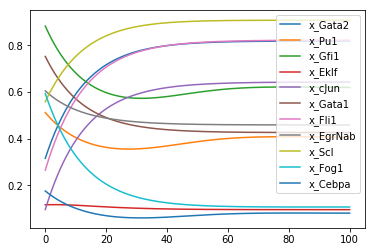

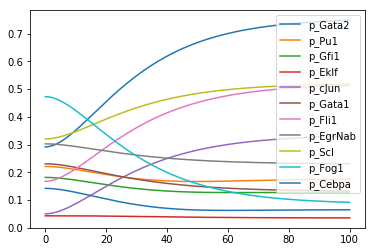

In [2]:
import sys
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
sys.path.insert(0, "/home/adyprat/anaconda3/envs/pyDSTool/lib/python3.6/site-packages/")
import PyDSTool as dst
from itertools import combinations
#np.random.seed(2019)
DF = pd.read_csv("variables.txt",sep='\t')
#DF = pd.read_csv("test_vars.txt",sep='\t')
genes = set(DF['Gene'].values)

keywd = ['and','not', 'or', '']
varspecs = {'x_' + g:'' for g in genes}



varspecs.update({'p_' + g:'r_'+g+'*'+'x_' +g +\
                 '- l_p_'+g+'*'+'p_' + g for g in genes})

#varspecs.update({'p_' + g:'l_p_'+g+'*'+'x_' +g +\
#                 '- l_p_'+g+'*'+'p_' + g for g in genes})



def getSaneNval(lo=1.,hi=10.,mu=2.,sig=2.):
    k = np.random.normal(mu, sig)
    while k < lo or k > hi:
        k = np.random.normal(mu, sig)
    return k

par = {'n_'+g:getSaneNval() for g in genes}
par.update({'k_'+g:getSaneNval(lo=0.01,hi=1.0,mu=0,sig=0.02) for g in genes}) # Common Thresholds, uniform dist
par.update({'a_'+g:getSaneNval(mu=0.25,sig=1.,lo=0,hi=1) for g in genes}) # basal activations, gaussian dist
par.update({'r_' + g:getSaneNval(lo=0.,hi=0.25,mu=0.0,sig=0.05) for g in genes})
#par.update({'l_x_' + g:np.log(2)/getSaneNval(mu=5,sig=10.,lo=0,hi=100) for g in genes})
lx = np.log(2)/getSaneNval(mu=5,sig=10.,lo=0,hi=100)
par.update({'l_x_' + g:lx for g in genes})
#par.update({'l_x_' + g:1 for g in genes})

#par.update({'l_p_' + g:np.log(2)/getSaneNval(mu=5,sig=10.,lo=0,hi=100) for g in genes})
lp = np.log(2)/getSaneNval(mu=5,sig=10.,lo=0,hi=100)
par.update({'l_p_' + g:lp for g in genes})


par.update({'m_' + g:1.0 for g in genes})
#ics = {'x_' + g:abs(np.random.normal(0.0,1.0)) for g in genes}
#ics = {'x_' + g:abs(np.random.normal(1.0,10.0)) for g in genes}
#ics = {'x_' + g:1 for g in genes}
ics = {'x_' + g:getSaneNval(lo=0.,hi=1,mu=0.0,sig=1) for g in genes}
ics.update({'p_' + g:ics['x_'+g]*par['r_'+g]/par['l_p_'+g] for g in genes})
#ics.update({'p_' + g:ics['x_'+g]/par['l_p_'+g] for g in genes})

for i,row in DF.iterrows():
    rhs = row['Rule']
    rhs = rhs.replace('(',' ')
    rhs = rhs.replace(')',' ')
    tokens = rhs.split(' ')

    reg = [t for t in tokens if t in genes]
    currGen = row['Gene']
    num = '( a_' + currGen
    den = '( 1'
    for i in range(1,len(reg) + 1):
        for c in combinations(reg,i):
            hills = ['(p_'+ci+'/k_'+ci+')^n_'+ci for ci in c]
            mult = '*'.join(hills)
            num += ' + a_' + currGen +'_'  + '_'.join(list(c)) + '*' + mult
            par['a_' + currGen +'_'  + '_'.join(list(c))] = getSaneNval(mu=0.25,sig=1.,lo=0,hi=1) 
            den += ' +' +  mult

    num += ' )'
    den += ' )'

    #varspecs['x_' + currGen] = 'm_'+ currGen + '*' + num + '/' + den + '-' + 'l_x_'  + currGen +'*x_' + currGen
    varspecs['x_' + currGen] = 'l_x_'+ currGen + '*' + num + '/' + den + '-' + 'l_x_'  + currGen +'*x_' + currGen


#print({p:par[p] for p in par if 'r_' in p})
#print({p:par[p] for p in par})
#print(genes)
#print(varspecs)
#print(par)

#par['a_a_c'] = 1 
#par['a_b_a'] = 0
#par['a_c_b'] = 1

#par['a_a'] = 0
#par['a_b'] = 1
#par['a_c'] = 0


#ics['x_a'] = 1
#ics['x_b'] = 0
#ics['x_c'] = 1
#ics.update({'p_' + g:ics['x_'+g]*par['r_'+g]/par['l_p_'+g] for g in genes})


ModelDef = dst.args(name='bool',
                    varspecs=varspecs,
                    pars=par,
                    ics=ics,
                    tdata=[0,100])
DS = dst.Vode_ODEsystem(ModelDef)

traj = DS.compute('test')

points = traj.sample()

for g in varspecs.keys():
    if 'x_' in g:
        plt.plot(points['t'], points[g],label=g)

plt.legend()
plt.show()

for g in varspecs.keys():
    if 'p_' in g:
        plt.plot(points['t'], points[g],label=g)

plt.legend()
plt.show()



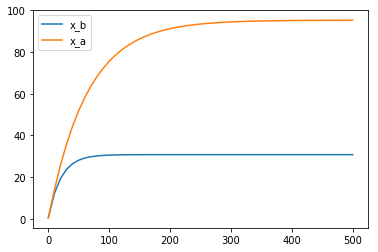

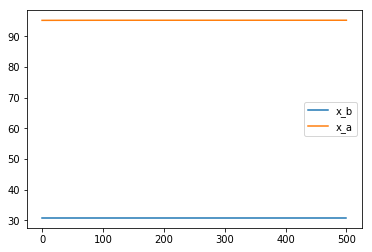

In [58]:
ics = {'x_' + g:abs(np.random.normal(0.0,0.5)) for g in genes}
ics.update({'p_' + g:ics['x_'+g]*par['r_'+g]/par['l_p_'+g] for g in genes})

DS.set(ics=ics,
       #pars=par
      tdata=[0,500])


traj = DS.compute('test')

points = traj.sample(dt=10.)

for g in varspecs.keys():
    if 'x_' in g:
        plt.plot(points['t'], points[g],label=g)
plt.legend()
plt.show()
ics = {v:points[v][-1] for v in varspecs.keys()}

DS.set(ics=ics,
       #pars=par
      tdata=[0,500])
traj = DS.compute('test1')

points = traj.sample(dt=10.)

for g in varspecs.keys():
    if 'x_' in g:
        plt.plot(points['t'], points[g],label=g)

plt.legend()
plt.show()

In [109]:
print({v:points[v][-1] for v in varspecs.keys()})

{'x_b': 0.40362986387106414, 'x_a': 44.561825472810476, 'p_b': 3.4930432720604934, 'p_a': 49.480386046445176}


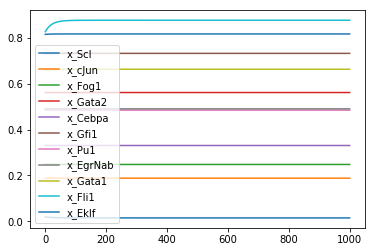

In [165]:
ics = {v:points[v][-1] for v in varspecs.keys()}

DS.set(ics=ics,
       #pars=par
      tdata=[0,1000])
traj = DS.compute('test1')

points = traj.sample()

for g in varspecs.keys():
    if 'x_' in g:
        plt.plot(points['t'], points[g],label=g)

plt.legend()
plt.show()

In [3]:
for g in varspecs.keys():
    if 'x_' in g:
        print(points['t'], points[g])
    df

[0.00000000e+00 1.00010001e-02 2.00020002e-02 ... 9.99799980e+01
 9.99899990e+01 1.00000000e+02] [0.31539121 0.31578806 0.31618461 ... 0.81809983 0.81809976 0.81809968]


NameError: name 'df' is not defined